# Overview #

The objective of this task is to build a model that predicts the quality of red wine given certain features. Wine quality ranges from 0 (poor) to 10 (excellent).

# Import libraries & define some variables #

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

TRAIN_DATASET = os.path.join('dataset', 'winequality-red.csv')

# Data Inspection and Preprocessing #

In [6]:
data = pd.read_csv(TRAIN_DATASET)
df = data.copy()
df.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
1,7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
2,7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...
3,11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...
4,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 1 columns):
fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"    1599 non-null object
dtypes: object(1)
memory usage: 12.6+ KB


Luckily, this dataset does not have any `NaN` values and all inputs are numeric.

# Exploratory Data Analysis #

In [8]:
plt.figure(figsize=(8, 8))
plt.hist(df['quality'], range=(0, 10))
plt.xlabel('Wine Quality')
plt.show()

KeyError: 'quality'

<Figure size 576x576 with 0 Axes>

Most of the red wine samples provided fall between 5 and 7; meaning that they are mostly good wine (not excellent). This could affect the strength of prediction of the model since it will learn more of what makes red wine good.

Studying the correlation between the features will give an idea of what features really affect wine quality positively or negatively.

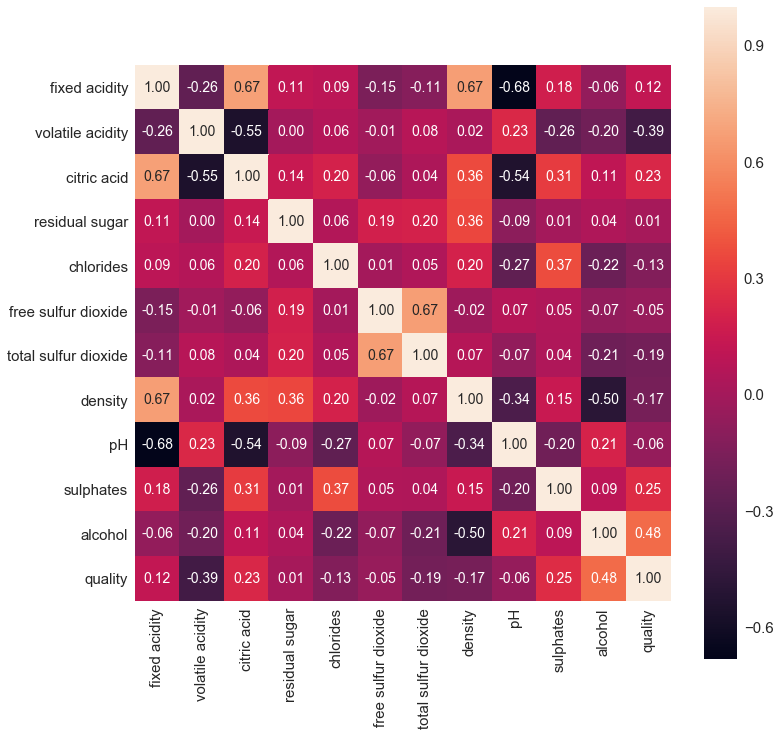

In [5]:
def heatmap(df):
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1.5)
    sns.heatmap(df.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=df.columns, 
                xticklabels=df.columns)
    plt.show()
    
heatmap(df)

We will exam features with strong correlation (>=0.45) between them.

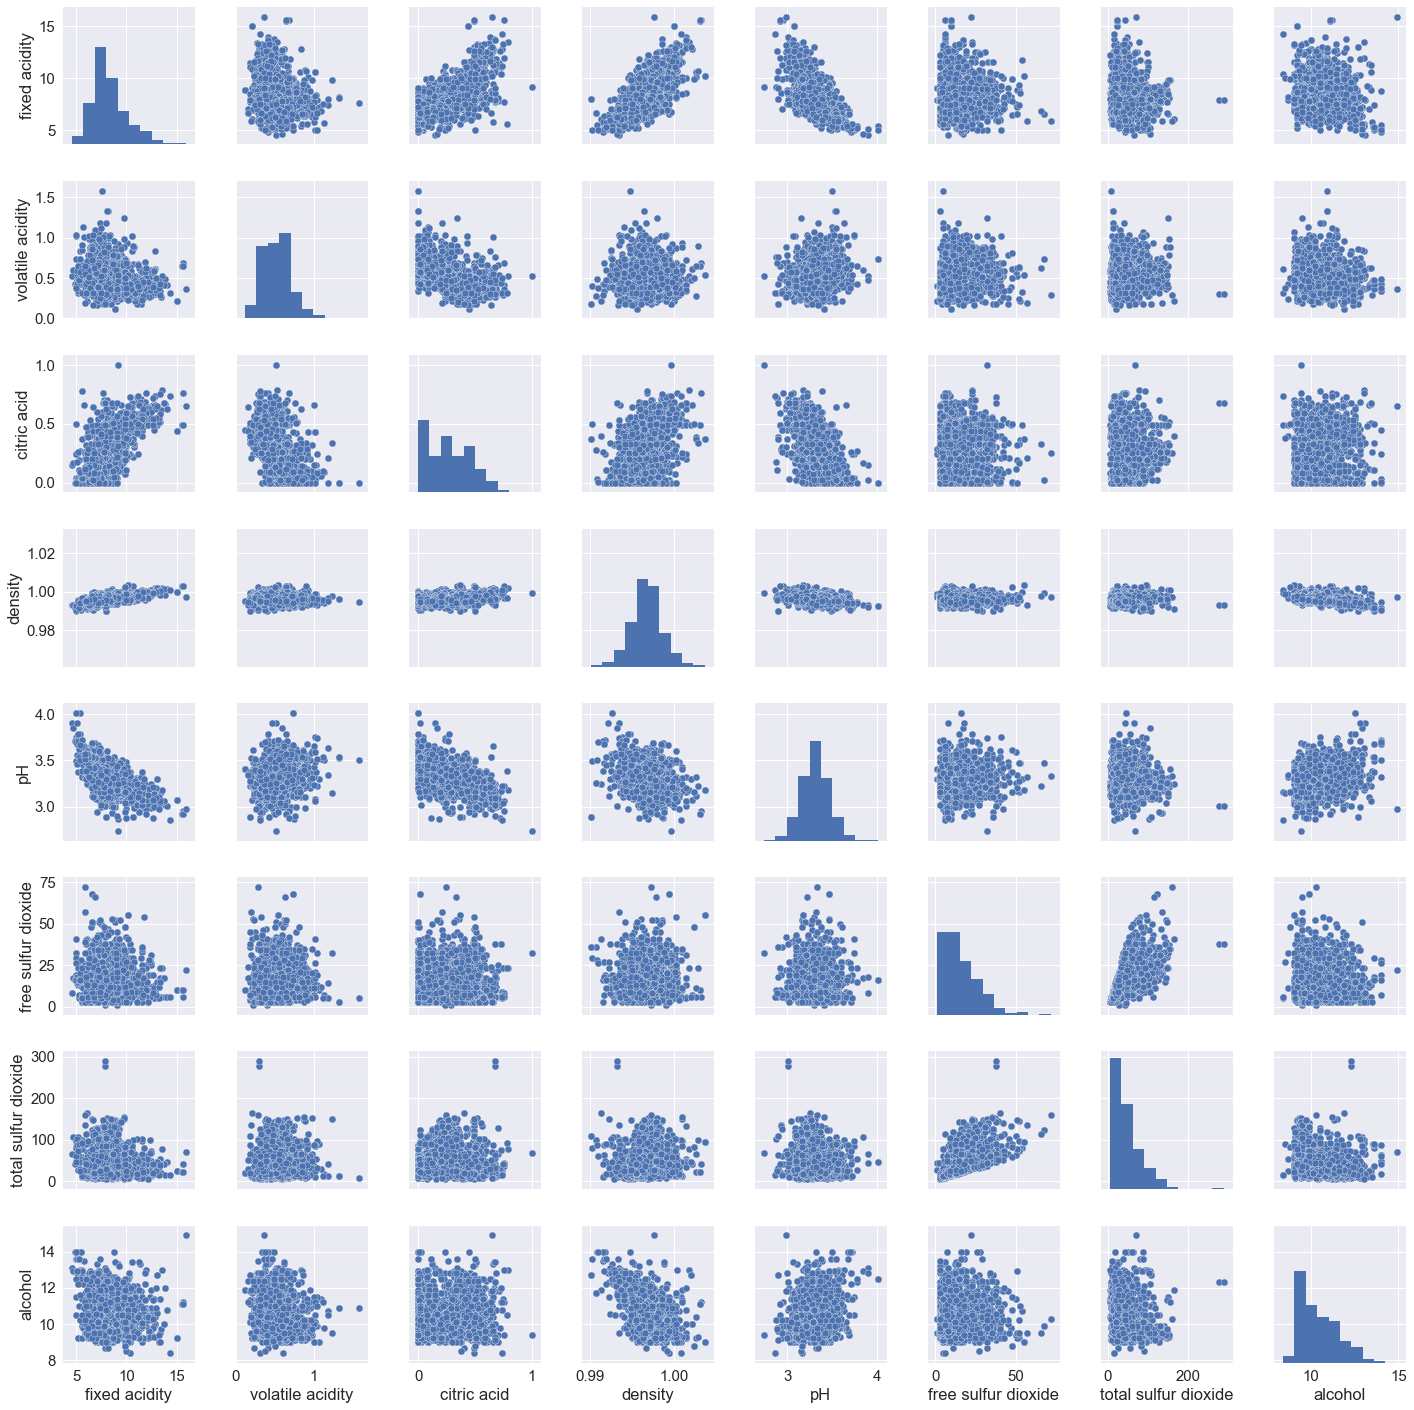

In [6]:
corr_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH', 'free sulfur dioxide', 
             'total sulfur dioxide', 'alcohol']

def pairplot(cols):
    sns.pairplot(df[cols])
    plt.show()
    
pairplot(corr_cols)

# Looking out for outliers #

The approach to be applied to looking for outliers will be to compare correlations between features and view the plot of points between these correlations. Correlation values greater than 0.5 and have "eye-balled" outliers from the pairplot will be analyzed.

In [7]:
from scipy import stats
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import polyfit
import random

def plot_relationship_best_fit(x_axis, x_label, y_axis, y_label, best_fit='linear'):
    fit = None
    
    if best_fit == 'linear':
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
        fit = slope * x_axis + intercept
#         c = polyfit(x_axis, y_axis, 1)
#         fit = c[0] + c[1]*x_axis
    
    if best_fit == 'quadratic':
        popt, pcov = curve_fit(func, x_axis, y_axis)
        fit = func(x_axis, *popt)
        
#         coef = polyfit(x_axis, y_axis, 2)
#         fit = coef[0] + coef[1]*x_axis + coef[2]*(x_axis**2)
        
    np.random.seed(42)
    r = random.randint(0, len(x_axis)-1)
    
    plt.figure(figsize=(8,8))    
    plt.scatter(x_axis, y_axis)
    plt.plot(x_axis, fit, color='r')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def func(x, a, b, c):
    return a*(x**2) + b*x + c

In [8]:
def corr_plot(x_axis, x_label, y_axis, y_label, title=None, legend=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(x_axis, y_axis)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

#### Fixed Acidity & Citric Acid ####

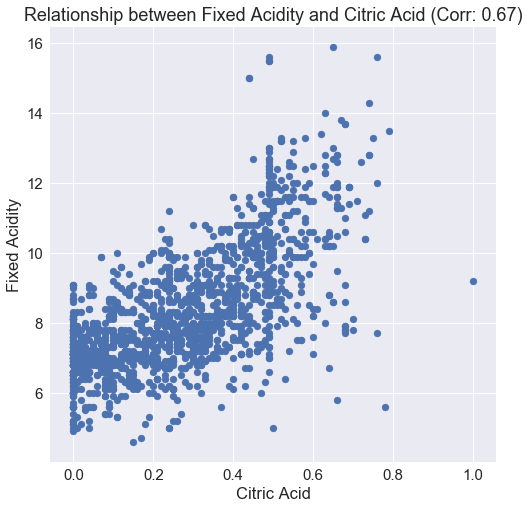

In [9]:
corr = 'Corr: %.2f' % df['fixed acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['fixed acidity'], 'Fixed Acidity', 
          'Relationship between Fixed Acidity and Citric Acid ({})'.format(corr))

We would expect that as the citric acid content increase, so does the fixed acidity because of a strong positive correlation between the two. From the plot, there are anomalies when citric acid is 0 (vertical line), 0.49 (vertical line) and 1.0. These points will be removed.

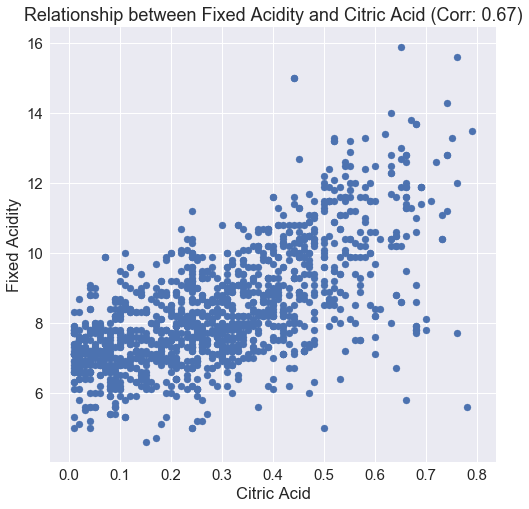

In [10]:
df = df[df['citric acid'] > 0]
df = df[df['citric acid'] != 0.49]
df = df[df['citric acid'] < 1.0]

corr = 'Corr: %.2f' % df['fixed acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['fixed acidity'], 'Fixed Acidity', 
          'Relationship between Fixed Acidity and Citric Acid ({})'.format(corr))

#### Fixed Acidity & Density ####

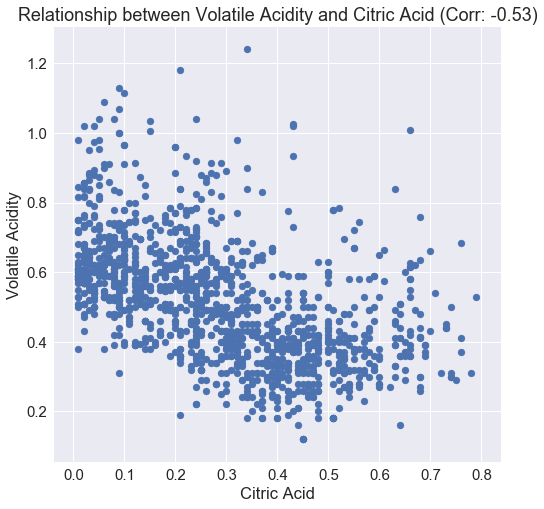

In [11]:
corr = 'Corr: %.2f' % df['volatile acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['volatile acidity'], 'Volatile Acidity', 
          'Relationship between Volatile Acidity and Citric Acid ({})'.format(corr))

Volatile acidity has a negative correlation with citric acid. This means that as citric acid increases, volatile acidity decreases. From the point, a few outliers are spotted that don't generalize to the negative correlation. Points at greater and 1.2 (volatile acidity), 1.18 (volatile acidity) and 1.01 (volatile acidity) will be removed.

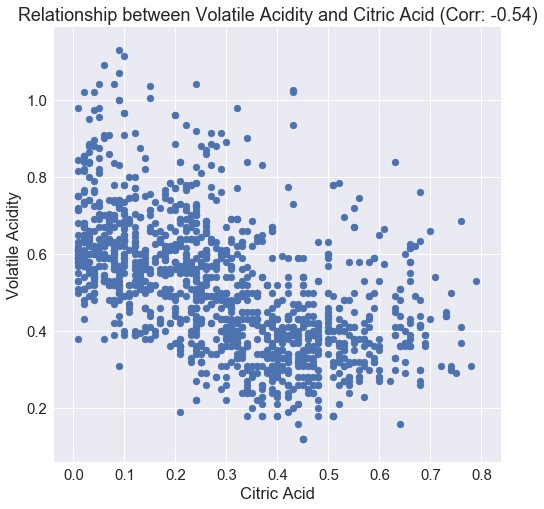

In [12]:
df = df[df['volatile acidity'] < 1.2]
df = df[df['volatile acidity'] != 1.18]
df = df[df['volatile acidity'] != 1.01]

corr = 'Corr: %.2f' % df['volatile acidity'].corr(df['citric acid'])
corr_plot(df['citric acid'], 'Citric Acid', df['volatile acidity'], 'Volatile Acidity', 
          'Relationship between Volatile Acidity and Citric Acid ({})'.format(corr))

#### Citric Acid & pH ####

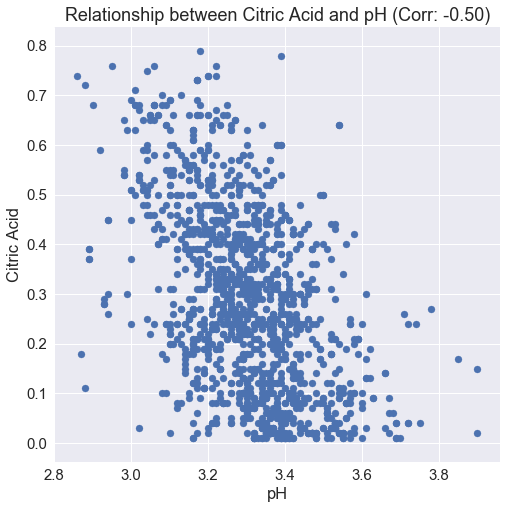

In [13]:
corr = 'Corr: %.2f' % df['citric acid'].corr(df['pH'])
corr_plot(df['pH'], 'pH', df['citric acid'], 'Citric Acid', 
          'Relationship between Citric Acid and pH ({})'.format(corr))

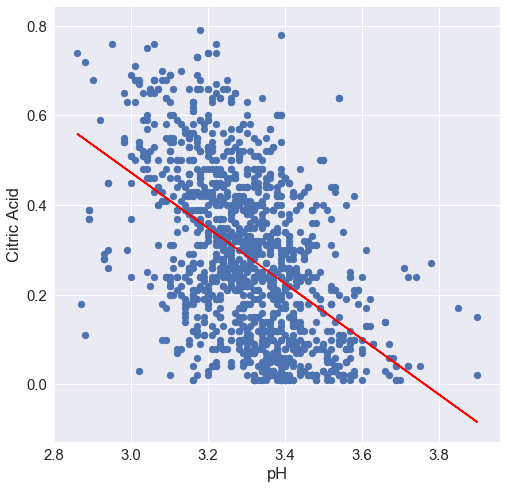

In [14]:
plot_relationship_best_fit(df['pH'], 'pH', df['citric acid'], 'Citric Acid')

The point at which citric acid is 0.78 will be removed.

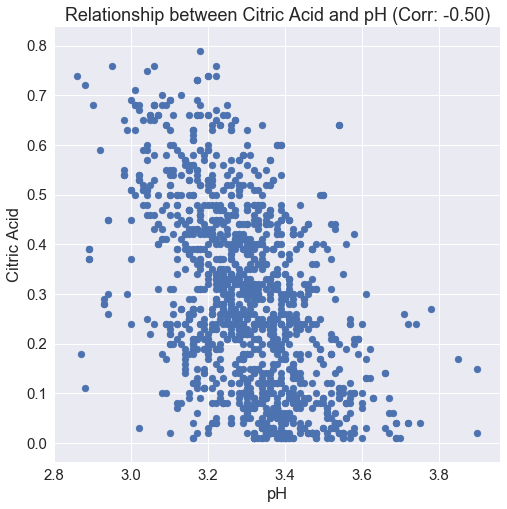

In [15]:
df = df[df['citric acid'] != 0.78]

corr = 'Corr: %.2f' % df['citric acid'].corr(df['pH'])
corr_plot(df['pH'], 'pH', df['citric acid'], 'Citric Acid', 
          'Relationship between Citric Acid and pH ({})'.format(corr))

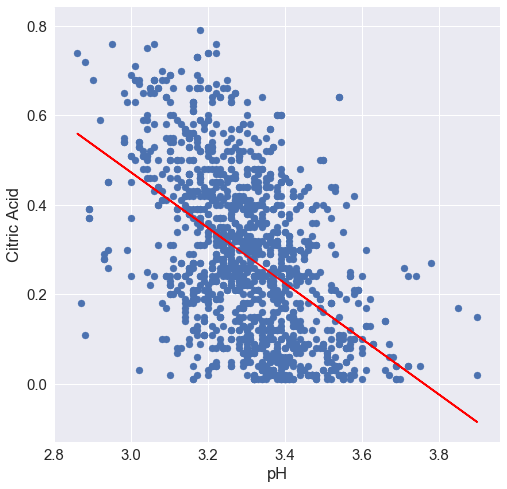

In [16]:
plot_relationship_best_fit(df['pH'], 'pH', df['citric acid'], 'Citric Acid')

#### Density & Fixed Acidity ####

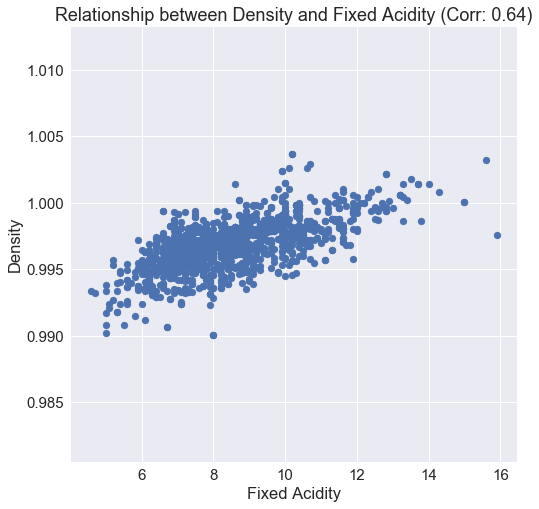

In [17]:
corr = 'Corr: %.2f' % df['density'].corr(df['fixed acidity'])
corr_plot(df['fixed acidity'], 'Fixed Acidity', df['density'], 'Density', 
          'Relationship between Density and Fixed Acidity ({})'.format(corr))

Points a which density is greater than 0.991 and fixed acidity is 15.9 will be removed.

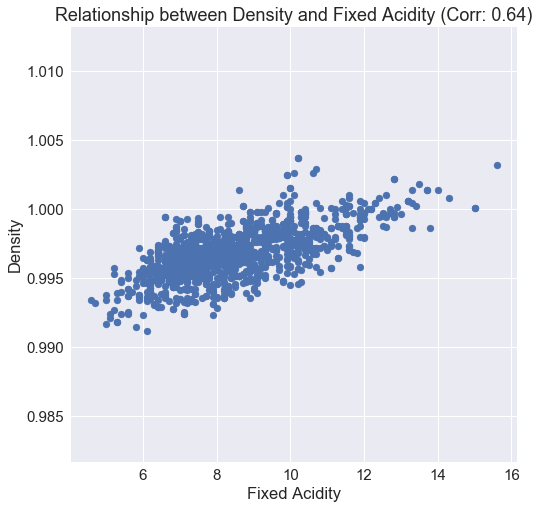

In [18]:
df = df[df['density'] > 0.991]
df = df[df['fixed acidity'] != 15.9]

corr_plot(df['fixed acidity'], 'Fixed Acidity', df['density'], 'Density', 
          'Relationship between Density and Fixed Acidity ({})'.format(corr))

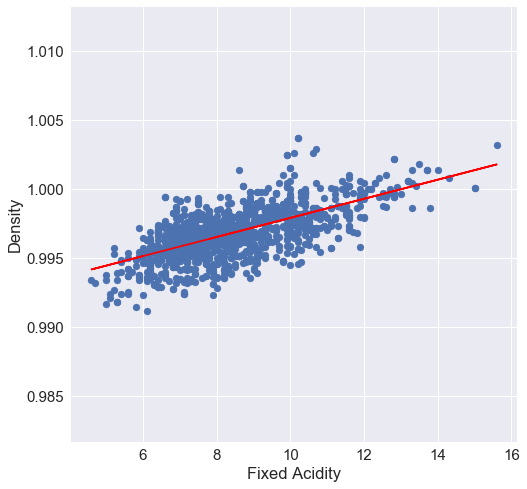

In [19]:
plot_relationship_best_fit(df['fixed acidity'], 'Fixed Acidity', df['density'], 'Density')

#### Density & Alcohol ####

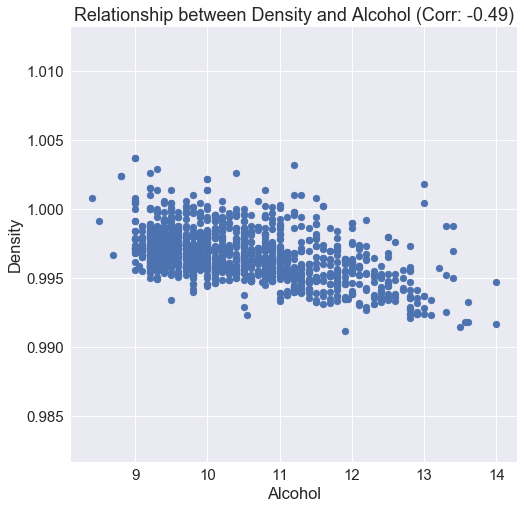

In [20]:
corr = 'Corr: %.2f' % df['density'].corr(df['alcohol'])
corr_plot(df['alcohol'], 'Alcohol', df['density'], 'Density', 
          'Relationship between Density and Alcohol ({})'.format(corr))

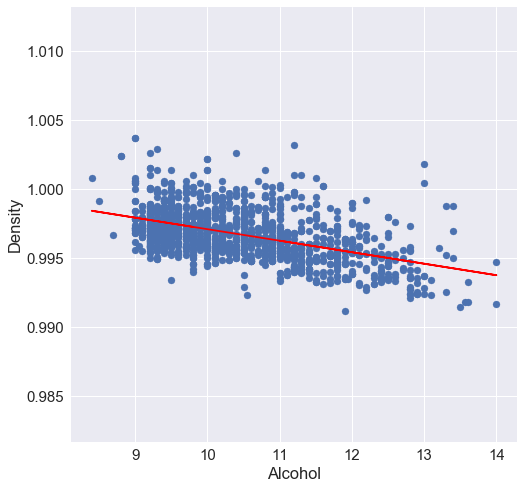

In [21]:
plot_relationship_best_fit(df['alcohol'], 'Alcohol', df['density'], 'Density')

#### pH & Fixed Acidity ####

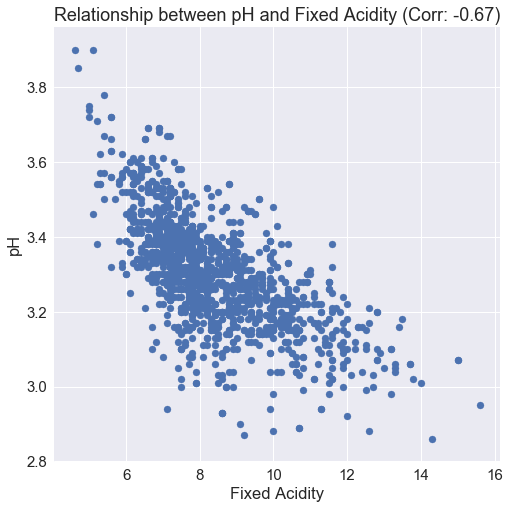

In [22]:
corr = 'Corr: %.2f' % df['pH'].corr(df['fixed acidity'])
corr_plot(df['fixed acidity'], 'Fixed Acidity', df['pH'], 'pH', 
          'Relationship between pH and Fixed Acidity ({})'.format(corr))

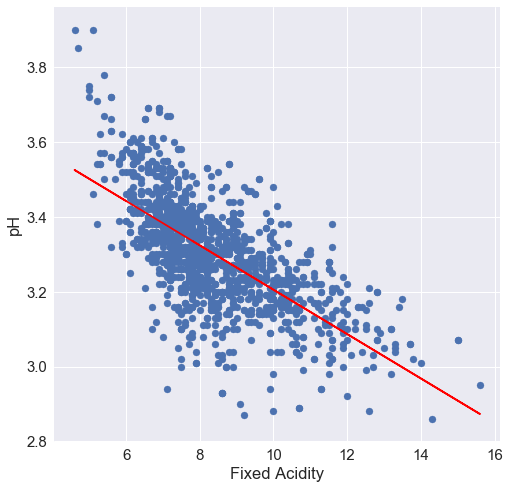

In [23]:
plot_relationship_best_fit(df['fixed acidity'], 'Fixed Acidity', df['pH'], 'pH')

#### Free Sulfur Dioxide & Total Sulfur Dioxied ####

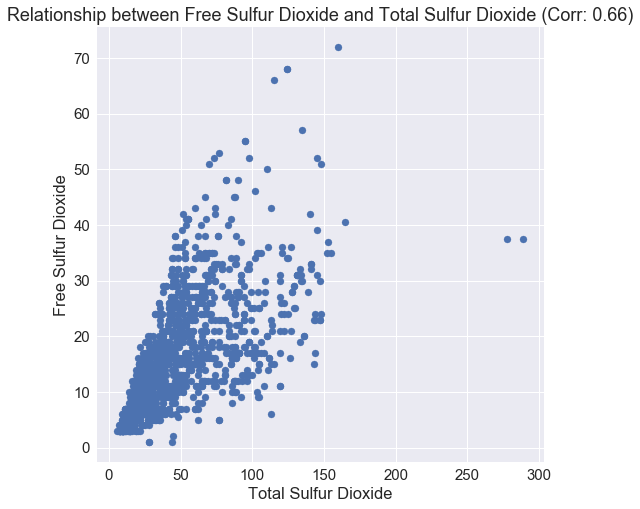

In [24]:
corr = 'Corr: %.2f' % df['free sulfur dioxide'].corr(df['total sulfur dioxide'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['free sulfur dioxide'], 'Free Sulfur Dioxide', 
          'Relationship between Free Sulfur Dioxide and Total Sulfur Dioxide ({})'.format(corr))

Clearly, total sulfur dioxide points greater than 250 are outliers.

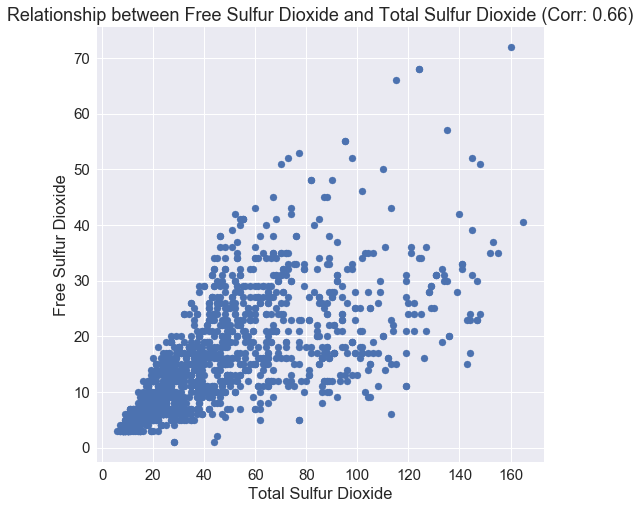

In [25]:
df = df[df['total sulfur dioxide'] < 250]

corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['free sulfur dioxide'], 'Free Sulfur Dioxide', 
          'Relationship between Free Sulfur Dioxide and Total Sulfur Dioxide ({})'.format(corr))

In [26]:
df.shape

(1384, 12)

# Feature Engineering #

Features will be engineered to create new features based on the relationship between the features and their correlation. From research, total acidity is made up of fixed acidity and volatile acidity. These features will be combined to one feature. Features that have a correlation greater than 0.4 will be combined to form new features.

In [28]:
df['total acidity'] = df['fixed acidity'] + df['volatile acidity']
df['fixed acidity citric acid'] = df['fixed acidity'] * df['citric acid']
df['fixed acidity density'] = df['fixed acidity'] * df['density']
df['fixed acidity pH'] = df['fixed acidity'] * df['pH']
df['volatile acidity citric acid'] = df['volatile acidity'] * df['citric acid']
df['citric acid pH'] = df['citric acid'] * df['pH']
df['sulfur dioxide content'] = df['total sulfur dioxide'] * df['free sulfur dioxide']
df['alcohol density'] = df['alcohol'] * df['density']
df['alcohol quality'] = df['alcohol'] * df['quality']


df.drop(['fixed acidity', 'volatile acidity', 'citric acid', 'density', 'pH', 'total sulfur dioxide', 
         'free sulfur dioxide', 'alcohol'], axis=1, inplace=True)
df = df.reset_index(drop=True)

In [29]:
df.shape

(1384, 13)

# Feature Scaling #

With outliers removed, the dataset will be scaled using the `StandardScaler` class. But first the data will be split into training and testing sets with a ration of 75% to 25%.

In [30]:
from sklearn.model_selection import train_test_split

random_state = 42
target = df['quality']
features = df.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=random_state)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1038, 12)
(346, 12)
(1038,)
(346,)


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model #

The model will be trained using a neural network architecture and will be evaluated using the `r2 score`. The Keras library will be used in developing the neural network architecture, compiling, training, evaluating the model and predicting wine quality. The architecture is made up of the input layer, 6 hidden layer and the output/prediction layer. Dropout is applied to the hidden layers to avoid overfitting.

In [32]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', 'accuracy'])
model.summary()

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                416       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

Early stopping will be used to stop the training once there is no change in the loss. The training will stop if there is no change in loss after 250 iterations. Because of the size of the dataset, the test data will be used for validation. The model does not train on the test data.

In [33]:
early_stopping = EarlyStopping(patience=250)
history = model.fit(X_train, y_train, epochs=1000, verbose=1, validation_split=.3, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

Train on 1038 samples, validate on 346 samples
Epoch 1/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 10.8009 - mean_absolute_error: 2.6716 - acc: 0.1098 - val_loss: 3.0397 - val_mean_absolute_error: 1.5105 - val_acc: 0.1503
Epoch 2/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 4.1395 - mean_absolute_error: 1.6533 - acc: 0.1917 - val_loss: 1.3531 - val_mean_absolute_error: 1.0119 - val_acc: 0.2139
Epoch 3/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 2.5340 - mean_absolute_error: 1.3125 - acc: 0.2004 - val_loss: 1.7853 - val_mean_absolute_error: 1.0303 - val_acc: 0.3237
Epoch 4/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 1.8778 - mean_absolute_error: 1.1117 - acc: 0.2746 - val_loss: 1.1472 - val_mean_absolute_error: 0.9683 - val_acc: 0.1734
Epoch 5/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 1.3098 - mean_absolute_error: 0.9034 - acc: 0.3651 - val_loss: 0.6651 - va

Epoch 82/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0971 - mean_absolute_error: 0.2434 - acc: 0.8988 - val_loss: 0.0176 - val_mean_absolute_error: 0.0776 - val_acc: 0.9769
Epoch 83/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.1042 - mean_absolute_error: 0.2500 - acc: 0.8825 - val_loss: 0.0230 - val_mean_absolute_error: 0.0665 - val_acc: 0.9769
Epoch 84/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.1135 - mean_absolute_error: 0.2486 - acc: 0.8940 - val_loss: 0.0197 - val_mean_absolute_error: 0.0752 - val_acc: 0.9769
Epoch 85/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0842 - mean_absolute_error: 0.2283 - acc: 0.9104 - val_loss: 0.1085 - val_mean_absolute_error: 0.2954 - val_acc: 0.9075
Epoch 86/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.1066 - mean_absolute_error: 0.2497 - acc: 0.8979 - val_loss: 0.0154 - val_mean_absolute_error: 0.0670 - val_acc: 0.

Epoch 163/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0516 - mean_absolute_error: 0.1740 - acc: 0.9672 - val_loss: 0.0421 - val_mean_absolute_error: 0.1594 - val_acc: 0.9566
Epoch 164/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0567 - mean_absolute_error: 0.1790 - acc: 0.9576 - val_loss: 0.0307 - val_mean_absolute_error: 0.1382 - val_acc: 0.9798
Epoch 165/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0531 - mean_absolute_error: 0.1792 - acc: 0.9692 - val_loss: 0.0078 - val_mean_absolute_error: 0.0527 - val_acc: 0.9884ss: 0.0586 - mean_absolute_error: 0.1886 
Epoch 166/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0519 - mean_absolute_error: 0.1752 - acc: 0.9730 - val_loss: 0.0172 - val_mean_absolute_error: 0.0510 - val_acc: 0.9769
Epoch 167/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0538 - mean_absolute_error: 0.1736 - acc: 0.9624 - val_loss: 0.0135 -

1038/1038 [==============================] - 3s 2ms/step - loss: 0.0421 - mean_absolute_error: 0.1608 - acc: 0.9788 - val_loss: 0.0080 - val_mean_absolute_error: 0.0666 - val_acc: 0.9942
Epoch 244/1000
1038/1038 [==============================] - 3s 2ms/step - loss: 0.0431 - mean_absolute_error: 0.1582 - acc: 0.9827 - val_loss: 0.0067 - val_mean_absolute_error: 0.0578 - val_acc: 0.9971
Epoch 245/1000
1038/1038 [==============================] - 3s 2ms/step - loss: 0.0428 - mean_absolute_error: 0.1583 - acc: 0.9769 - val_loss: 0.0168 - val_mean_absolute_error: 0.0972 - val_acc: 0.9827
Epoch 246/1000
1038/1038 [==============================] - 3s 2ms/step - loss: 0.0452 - mean_absolute_error: 0.1651 - acc: 0.9711 - val_loss: 0.0072 - val_mean_absolute_error: 0.0374 - val_acc: 0.9942
Epoch 247/1000
1038/1038 [==============================] - 2s 2ms/step - loss: 0.0402 - mean_absolute_error: 0.1580 - acc: 0.9807 - val_loss: 0.0092 - val_mean_absolute_error: 0.0795 - val_acc: 0.9971
Epoch

1038/1038 [==============================] - 3s 3ms/step - loss: 0.0366 - mean_absolute_error: 0.1471 - acc: 0.9846 - val_loss: 0.0065 - val_mean_absolute_error: 0.0481 - val_acc: 0.9913
Epoch 324/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0391 - mean_absolute_error: 0.1506 - acc: 0.9827 - val_loss: 0.0080 - val_mean_absolute_error: 0.0436 - val_acc: 0.9942
Epoch 325/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0357 - mean_absolute_error: 0.1461 - acc: 0.9846 - val_loss: 0.0159 - val_mean_absolute_error: 0.1064 - val_acc: 1.0000
Epoch 326/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0411 - mean_absolute_error: 0.1538 - acc: 0.9807 - val_loss: 0.0123 - val_mean_absolute_error: 0.1026 - val_acc: 0.9971
Epoch 327/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0374 - mean_absolute_error: 0.1526 - acc: 0.9855 - val_loss: 0.0122 - val_mean_absolute_error: 0.0989 - val_acc: 1.0000
Epoch

Epoch 404/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0337 - mean_absolute_error: 0.1419 - acc: 0.9855 - val_loss: 0.0071 - val_mean_absolute_error: 0.0695 - val_acc: 1.0000
Epoch 405/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0319 - mean_absolute_error: 0.1386 - acc: 0.9894 - val_loss: 0.0094 - val_mean_absolute_error: 0.0893 - val_acc: 1.0000
Epoch 406/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0315 - mean_absolute_error: 0.1394 - acc: 0.9942 - val_loss: 0.0065 - val_mean_absolute_error: 0.0377 - val_acc: 0.9942
Epoch 407/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0340 - mean_absolute_error: 0.1435 - acc: 0.9894 - val_loss: 0.0064 - val_mean_absolute_error: 0.0755 - val_acc: 1.0000
Epoch 408/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0364 - mean_absolute_error: 0.1435 - acc: 0.9836 - val_loss: 0.0080 - val_mean_absolute_error: 0.0598 - val_ac

1038/1038 [==============================] - 3s 3ms/step - loss: 0.0320 - mean_absolute_error: 0.1365 - acc: 0.9875 - val_loss: 0.0017 - val_mean_absolute_error: 0.0320 - val_acc: 1.0000
Epoch 485/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0331 - mean_absolute_error: 0.1359 - acc: 0.9827 - val_loss: 0.0019 - val_mean_absolute_error: 0.0367 - val_acc: 1.0000
Epoch 486/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0325 - mean_absolute_error: 0.1376 - acc: 0.9894 - val_loss: 0.0037 - val_mean_absolute_error: 0.0192 - val_acc: 0.9971
Epoch 487/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0314 - mean_absolute_error: 0.1344 - acc: 0.9865 - val_loss: 0.0152 - val_mean_absolute_error: 0.1090 - val_acc: 0.9971
Epoch 488/1000
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0326 - mean_absolute_error: 0.1368 - acc: 0.9894 - val_loss: 0.0213 - val_mean_absolute_error: 0.1205 - val_acc: 0.9971
Epoch

# Visualize Training Errors #

In [34]:
def plot_error(train_errors, val_errors, xlabel, ylabel, title=None, legend=None):
    plt.figure(figsize=(8, 8))
    plt.plot(train_errors)
    plt.plot(val_errors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(legend, loc='best')
    plt.show()

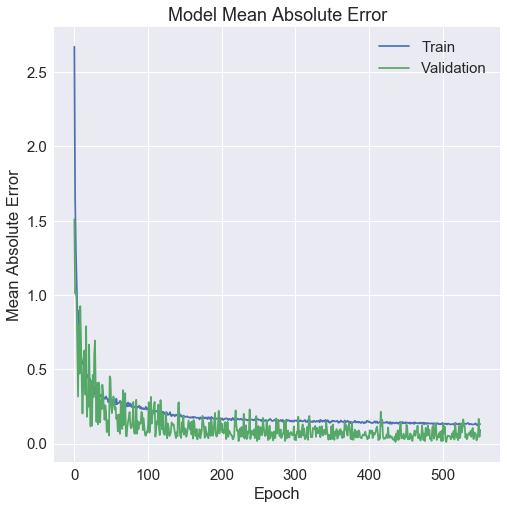

In [35]:
# Plot training & validation mean absolute values
plot_error(history.history['mean_absolute_error'], history.history['val_mean_absolute_error'], 'Epoch', 
           'Mean Absolute Error', 'Model Mean Absolute Error', ['Train', 'Validation'])

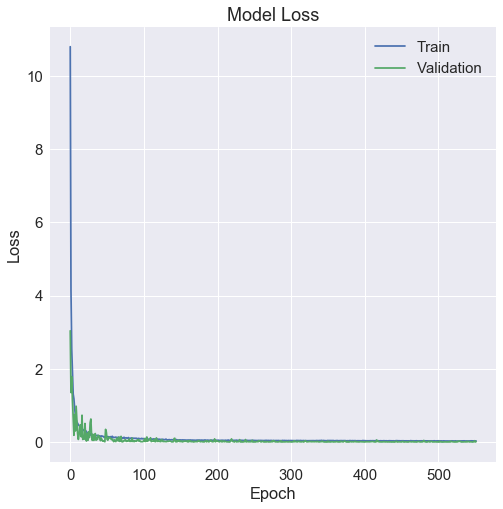

In [36]:
# Plot training & validation loss values
plot_error(history.history['loss'], history.history['val_loss'], 'Epoch', 'Loss', 'Model Loss', ['Train', 'Validation'])

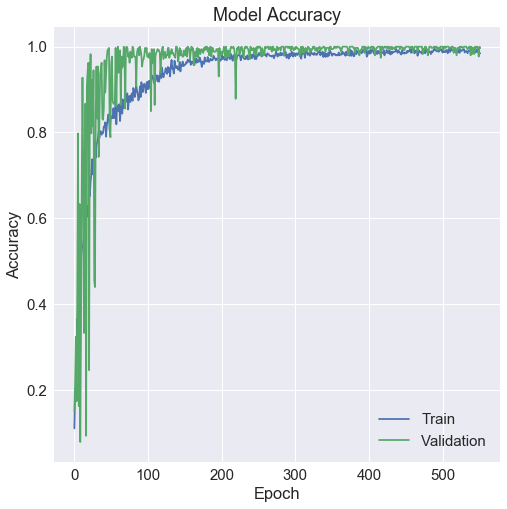

In [37]:
# Plot training & validation accuracy values
plot_error(history.history['acc'], history.history['val_acc'], 'Epoch', 'Accuracy', 'Model Accuracy', ['Train', 'Validation'])

# Make predictions #

Predictions will be rounded to their nearest units so as to easily compare with the test dataset's wine quality. The neural network predictions are returned as an array of arrays. These will be reshaped to a 1D array of predictions so that they can be compared with their ground-truth values (`y_test`).

In [38]:
predictions = model.predict(X_test)
predictions = np.reshape(predictions, predictions.shape[0])
predictions = np.round(predictions)

# Evaluate the model #

In [39]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print('R2 Score: %.3f' % r2)

R2 Score: 0.996


The plot below compares the predictions of the model with the corresponding ground-truth values.

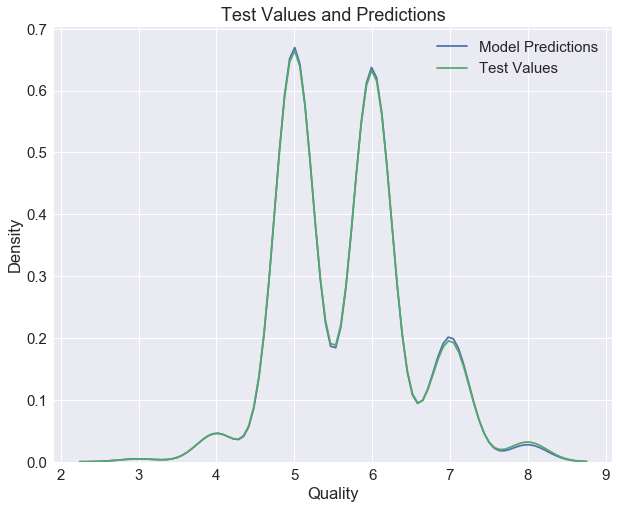

In [40]:
def evaluation_plot(y_test, predictions):
    plt.figure(figsize=(10, 8))

    # Density plot of the final predictions and the test values
    sns.kdeplot(predictions, label='Model Predictions')
    sns.kdeplot(y_test, label='Test Values')

    # Label the plot
    plt.xlabel('Quality')
    plt.ylabel('Density')
    plt.title('Test Values and Predictions')
    plt.show()

evaluation_plot(y_test, predictions)

# Conclusion #

With a `r2 score` of 99.6%, the model attempts to predict the ground-truth values of wine quality. The density plot gives an idea of how well the model's prediction matches the ground-truth values.